# Preprocessing Data: DataFrame with Pandas

The data is split into 2 CSV files, true and fake news. We will first view the two files seperately and then merge in order to split into train and test datasets. 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake (1).csv
Saving True.csv to True (1).csv


In [3]:
# Import dependencies
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding

from collections import Counter
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#  Import and read the Fake.csv.
fake_news_df = pd.read_csv(io.BytesIO(uploaded['Fake.csv']))
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Viewing the shape and types of data.

In [5]:
fake_news_df.nunique()

title      17903
text       17455
subject        6
date        1681
dtype: int64

In [6]:
fake_news_df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [7]:
#  Import and read the True.csv.
true_news_df = pd.read_csv(io.BytesIO(uploaded['True.csv']))
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
true_news_df.nunique()

title      20826
text       21192
subject        2
date         716
dtype: int64

In [9]:
true_news_df['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

Labelling the data to prepare for the supervised machine learning model.

In [10]:
# Label fake and real data 0 and 1 
true_news_df['label']=1
fake_news_df['label']=0

Merging the dataframes and dropping columns that will skew the data.

In [11]:
# Merge dfs
frames = [true_news_df, fake_news_df]
real_or_fake_df = pd.concat(frames)

# Drop subject columns as will skew the data 
real_or_fake_df=real_or_fake_df.drop(columns=['subject'],axis=1)
# Drop date column as data not needed 
real_or_fake_df=real_or_fake_df.drop(columns=['date'],axis=1)

In [12]:
real_or_fake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


Checking for duplicates, which will again skew the data and potentially lead to an overfitted model.

In [13]:
real_or_fake_df.duplicated().sum()

5793

In [14]:
real_or_fake_df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [15]:
real_or_fake_df.drop_duplicates()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
22698,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,0
22699,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,0
22700,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,0
22701,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,0


In [16]:
real_or_fake_df.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [17]:
real_or_fake_df.groupby('label').describe()

title                                                                 \
       count unique                                                top freq   
label                                                                         
0      23481  17903  MEDIA IGNORES Time That Bill Clinton FIRED His...    6   
1      21417  20826  Factbox: Trump fills top jobs for his administ...   14   

        text                                                                 
       count unique                                                top freq  
label                                                                        
0      23481  17455                                                     626  
1      21417  21192  (Reuters) - Highlights for U.S. President Dona...    8

In [ ]:
# ANY VISUALISATIONS?
# plot time period
# plot subjects 
# word clouds?
# pie chart fake and true 

# Preprocessing Data: NLP with tokenize

Tokenizing and removing stop words from the 'title' text. The totles have been broken down into tokens to enable the words and sequence in which they occur to be analysed. In this notebook we have tokenized the 'title' using the spaces in between words. 

Stop words are removed to reduce the noise and dimension of dataset. 

This notebook has used NLTK and keras to tokenize the dataset. 


In [52]:
# Tokenization v1
tokenizer = Tokenizer(filters='!""#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890...', lower=True, split=' ')
tokenizer.fit_on_texts(real_or_fake_df['title'])

def prep_text(texts, tokenizer):
    # Turns text into into padded sequences.
    text_sequences = tokenizer.texts_to_sequences(texts)
    return sequence.pad_sequences(text_sequences)

text_train_test = prep_text(real_or_fake_df['title'], tokenizer)

In [19]:
# Tokenization v2
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
X = real_or_fake_df.apply(lambda row: remove_stop_words(row['title']), axis=1)
y = real_or_fake_df['label']

In [20]:
# Tokenize & Sequence X
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences)

In [21]:
X_df = pd.DataFrame(X)
X_df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,184,129,1551,31,3536,2488,6166
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,87,1429,521,4061,1380,584
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,509,15,59,656,326
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,48,13,88,1449,1165,1381,1222
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,98,7342,514,1001,2092,6718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0,0,0,0,0,0,0,0,0,0,...,0,14270,221,333,807,38,3071,46,5523,1404
44894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,203,3417,5742,2097,1453,2394
44895,0,0,0,0,0,0,0,0,0,0,...,46,7706,1440,1967,60,118,7814,9357,808,51
44896,0,0,0,0,0,0,0,0,0,0,...,0,0,871,89,594,7731,36,588,27,1395


In [23]:
word_index = tokenizer.word_index

In [24]:
word_index_df = pd.DataFrame.from_dict(word_index, orient='index')
word_index_df.head()

,0
trump,1
video,2
says,3
obama,4
hillary,5


In [25]:
word_index_df.sort_values(0, ascending=False).head(5)

,0
ranching,19777
dictates,19776
mosteller,19775
trimester,19774
shushing,19773


In [53]:
word_index_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19777 entries, trump to ranching
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       19777 non-null  int64
dtypes: int64(1)
memory usage: 309.0+ KB


In [ ]:
# VISUALISATIONS HERE?
# Histogram?

# Train & Test Model

In [26]:
# For v1 of tokenization 
#y = real_or_fake_df['label']
#X = text_train_test

# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Naive Bayes Classifier
Multinomial Naive Bayes classifier has been used as the data is discrete. 

In [27]:
# Classification Model: Naive Bayes Classifier
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(score)

0.693170007423905


# Neural Networks
Binary classifier 

In [88]:
# Neural Networks Model  - binary classifier
# Create the model 
nn_model = Sequential() 
nn_model.add(Embedding(19777, 8, input_length=26)) 
nn_model.add(Flatten())
nn_model.add(Dense(52, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 26, 8)             158216    
                                                                 
 flatten_12 (Flatten)        (None, 208)               0         
                                                                 
 dense_26 (Dense)            (None, 52)                10868     
                                                                 
 dense_27 (Dense)            (None, 1)                 53        
                                                                 
Total params: 169,137
Trainable params: 169,137
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Train the model 
history = nn_model.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=32)

Epoch 1/5
688/688 [==============================] - 4s 5ms/step - loss: 0.2510 - accuracy: 0.8928 - val_loss: 0.1410 - val_accuracy: 0.9442
Epoch 2/5
688/688 [==============================] - 3s 4ms/step - loss: 0.0693 - accuracy: 0.9743 - val_loss: 0.1268 - val_accuracy: 0.9524
Epoch 3/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.1537 - val_accuracy: 0.9461
Epoch 4/5
688/688 [==============================] - 5s 8ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.1795 - val_accuracy: 0.9432
Epoch 5/5
688/688 [==============================] - 3s 5ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.1888 - val_accuracy: 0.9473


In [90]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}") 

InvalidArgumentError: ignored

[]

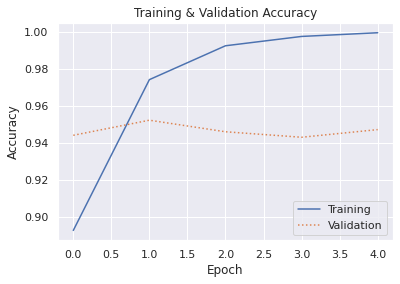

In [91]:
%matplotlib inline
sns.set()

acc = history.history['accuracy']
val = history.history['val_accuracy']

plt.plot(acc, '-', label='Training')
plt.plot(val, ':', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

# Model Optimisation